In [1]:
#import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import time
from IPython.display import HTML, display
from category_encoders import CountEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
print(data['neighbourhood_group'].unique())
print(data['room_type'].unique())

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Private room' 'Entire home/apt' 'Shared room']


In [3]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


<AxesSubplot:>

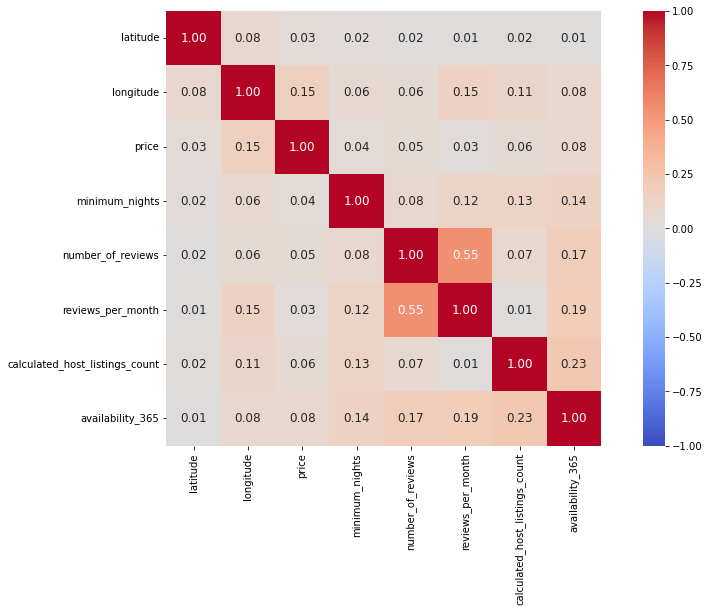

In [4]:
plt.figure(figsize=(15,8))
sns.heatmap(abs(data.corr()), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, vmin=-1, center=0,\
                        cmap=sns.color_palette('coolwarm',1000))

### Если у этого есть координаты, почему бы это не посмотреть на карте. Посмотрим распределение цен по квантилям.

In [5]:
# price_bins=data.price.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# data['PriceGroups'] = pd.cut(data['price'], price_bins, \
#                              labels=['0-0.1', '0.1-0.2', '0.2-0.3','0.3-0.4','0.4-0.5',\
#                                      '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1'], 
#                              right=True, include_lowest=True) 

# fig, ax = plt.subplots(figsize=(10,20))


# shape_df = gpd.read_file('nyad.shp').to_crs('EPSG:4326')
# shape_df.plot(ax=ax, color='lightgrey', zorder=1, edgecolor='black', linewidth=1)
# sns.kdeplot(x=data["longitude"], y=data["latitude"], hue=data['PriceGroups'], palette='rocket_r', alpha=0.2, fill=True)

# # условная точка Манхетенна
# sns.scatterplot(x=[-73.993], y=[40.750]) 

# # условная точка Бруклина
# sns.scatterplot(x=[-73.957], y=[40.711])
# data = data.drop(['PriceGroups'], axis=1)

### Самое что ни на есть Манхэттенское расстояние (в градусах, без учёта преград, дорог и т.д.)

 #### Добавим признаки удалённости жилья от данных точек

In [6]:
data['dist_to_manh'] = (abs(data['longitude'] + 73.993) + abs(data['latitude'] - 40.750))
data[['price','dist_to_manh']].corr() # Посмотрим на ёё корреляцию с целевой переменной

,price,dist_to_manh
price,1.000000,-0.183975
dist_to_manh,-0.183975,1.000000


In [7]:
def build_heatmap(data, k=2):
    plt.figure(figsize=(10,8))
    corrmat = abs(data.corr())
    cols = corrmat.nlargest(k, 'price')['price'].index.tolist()
    cm = np.corrcoef(data[cols].values.T)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                    yticklabels=cols, xticklabels=cols, vmin=-1, center=0,\
                        cmap=sns.color_palette('coolwarm',1000))
    plt.show()

### Мы можем наблюдать множество аномальных цен

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


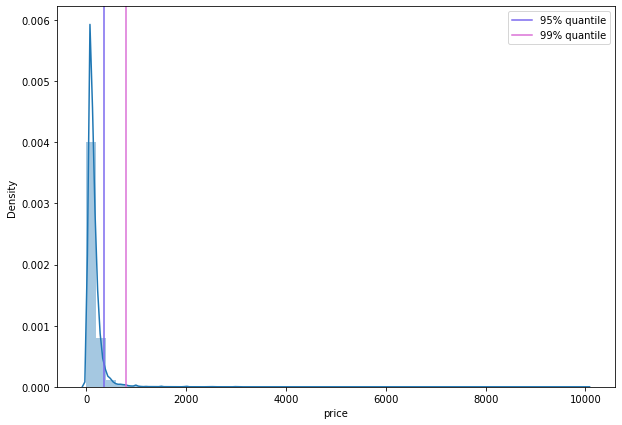

In [8]:
plt.subplots(figsize=(10,7))
sns.distplot(data['price'])
plt.axvline(data.price.quantile(0.95), label='95% quantile', c='mediumslateblue')
plt.axvline(data.price.quantile(0.99), label='99% quantile', c='orchid')
plt.legend()
plt.show()

### Обрежем данные по 90%-ому квантилю целевой переменной

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

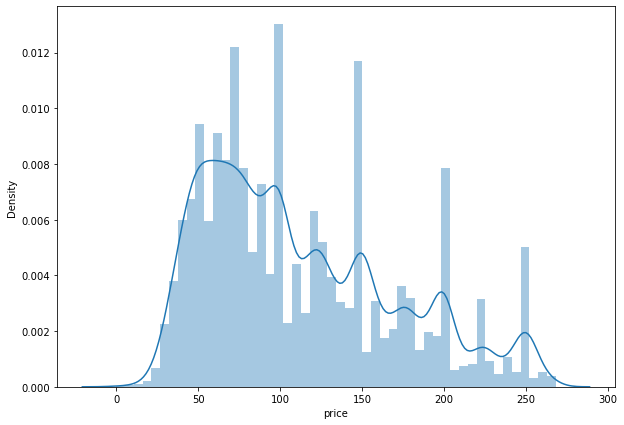

In [9]:
data=data.loc[data.price<data.price.quantile(0.90)]
plt.subplots(figsize=(10,7))
sns.distplot(data['price'])

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

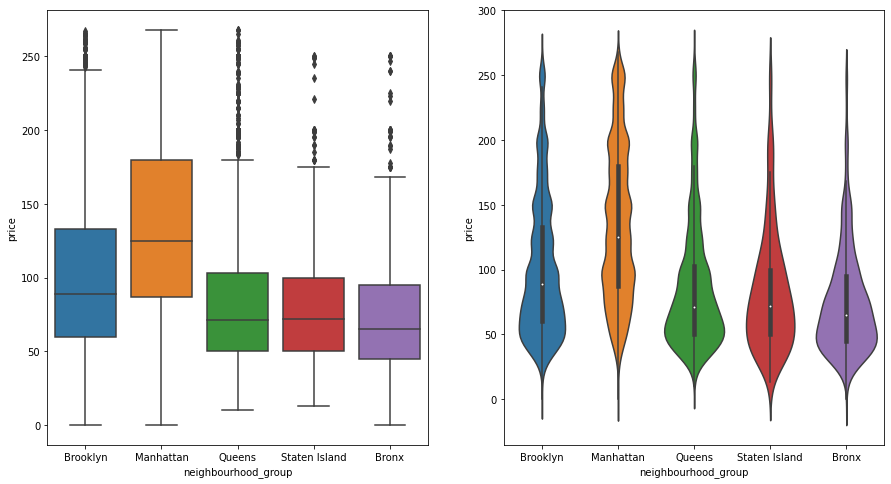

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15, 8))
sns.boxplot(ax=ax[0], data=data, x='neighbourhood_group', y='price')
sns.violinplot(ax=ax[1], data=data, x='neighbourhood_group', y='price')

### Логарифмируем целевую переменную

In [11]:
data['price'] = np.log1p(data.price)

### Nan в reviews_per_month заполним нулями

In [12]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

### Перекодируем районы по принципу Ordinary Encode по мере увеличения средней стоимости жилья

In [13]:
data.groupby('neighbourhood_group').mean()['price'].sort_values()

neighbourhood_group
Bronx            4.198906
Staten Island    4.296415
Queens           4.332228
Brooklyn         4.488223
Manhattan        4.803266
Name: price, dtype: float64

In [14]:
data.groupby('neighbourhood').mean()['price'].sort_values()

neighbourhood
Van Nest        3.802393
Bull's Head     3.819775
Tremont         3.840318
Hunts Point     3.863146
Concord         3.879344
                  ...   
West Village    5.139963
NoHo            5.186785
Neponsit        5.303305
Breezy Point    5.360561
Willowbrook     5.521461
Name: price, Length: 219, dtype: float64

In [15]:
from category_encoders import OrdinalEncoder, OneHotEncoder

enc = OneHotEncoder()
data = data.drop(['neighbourhood_group', 'room_type'], axis = 1).join(enc.fit_transform(data[['neighbourhood_group', 'room_type']], axis = 0))

In [16]:
neighbourhoods = data.groupby('neighbourhood').mean()['price'].sort_values().index.to_list()
encoded_neighbourhoods = {val:i+1 for i, val in enumerate(neighbourhoods)}
data = data.replace({'neighbourhood':encoded_neighbourhoods})

### Повторно оценим матрицу корреляций

<Figure size 720x576 with 0 Axes>

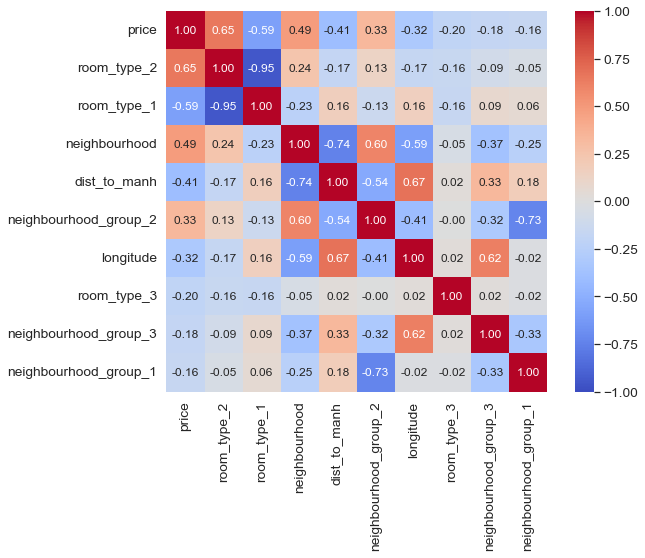

In [17]:
build_heatmap(data, 10)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['price'], axis=1), 
                                                    data['price'], test_size=0.30, 
                                                    random_state=42)

In [19]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error


scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())
regressors = (RidgeCV(), LassoCV(), ElasticNetCV())

for scaler in scalers:
    for regressor in regressors:
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        print('accuracy ' + str(regressor.score(X_test, y_test)))
        print('r2_score ' + str(r2_score(y_test, y_pred)))
        print('RMSE ' + str(mean_squared_error(y_test, y_pred, squared=False)))
        print('MAE ' + str(mean_absolute_error(y_test, y_pred)))
        print(type(scaler))
        print(type(regressor))
        print('==' * 20)

accuracy 0.5849960651505222
r2_score 0.5849960651505222
RMSE 0.34769118680558714
MAE 0.2696866883766228
<class 'sklearn.preprocessing._data.RobustScaler'>
<class 'sklearn.linear_model._ridge.RidgeCV'>
accuracy 0.5835183243371975
r2_score 0.5835183243371975
RMSE 0.3483096639400086
MAE 0.2708292742044752
<class 'sklearn.preprocessing._data.RobustScaler'>
<class 'sklearn.linear_model._coordinate_descent.LassoCV'>
accuracy 0.583294098428838
r2_score 0.583294098428838
RMSE 0.34840341301263217
MAE 0.2710284596595598
<class 'sklearn.preprocessing._data.RobustScaler'>
<class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>
accuracy 0.5849912476561305
r2_score 0.5849912476561305
RMSE 0.34769320485329813
MAE 0.26968985929423434
<class 'sklearn.preprocessing._data.StandardScaler'>
<class 'sklearn.linear_model._ridge.RidgeCV'>


D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0501316581171523, tolerance: 0.9166904553846964
  model = cd_fast.enet_coordinate_descent(


accuracy 0.5849639888363423
r2_score 0.5849639888363423
RMSE 0.34770462334837127
MAE 0.2697528592708972
<class 'sklearn.preprocessing._data.StandardScaler'>
<class 'sklearn.linear_model._coordinate_descent.LassoCV'>
accuracy 0.5849616746262898
r2_score 0.5849616746262898
RMSE 0.34770559273463086
MAE 0.2697588121774094
<class 'sklearn.preprocessing._data.StandardScaler'>
<class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>
accuracy 0.5848027819955416
r2_score 0.5848027819955416
RMSE 0.34777214390140165
MAE 0.26987327409552214
<class 'sklearn.preprocessing._data.MinMaxScaler'>
<class 'sklearn.linear_model._ridge.RidgeCV'>
accuracy 0.5838904377707961
r2_score 0.5838904377707961
RMSE 0.3481540272381985
MAE 0.27041182216921666
<class 'sklearn.preprocessing._data.MinMaxScaler'>
<class 'sklearn.linear_model._coordinate_descent.LassoCV'>
accuracy 0.5824454642543049
r2_score 0.5824454642543049
RMSE 0.34875799961803106
MAE 0.271086412702117
<class 'sklearn.preprocessing._data.MinMaxSc